<a href="https://colab.research.google.com/github/NosenkoArtem/MADMO-advanced-/blob/master/%22hw_5_metric_learning_small_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Metric Learning

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.sampler import Sampler, BatchSampler
from torch.nn.modules.loss import MSELoss

Вам необходимо реализовать вычисление Contrastive Loss - одну из самых популярных функций потерь для metric learning. Contrastive Loss получает на вход пару векторов $x_i$ и $x_j$ (признаковые описания объектов $i$ и $j$, полученные нейросетью) и метку $y_{ij}$, причем $y_{ij} = 0$, если объекты "похожи" (принадлежат одному классу), и $y_{ij} = 1$, если объекты "различны" (принадлежат различным классам). Формально определим Contrastive Loss следующим образом:

$$
L(x_i, x_j, y_{ij}) = (1 - y_{ij})\|x_i - x_j\|^2 + y_{ij}max(0, m - \|x_i - x_j\|^2)
$$

где $m$ - гиперпараметр (его можно взять равным единице).

Вместо того, чтобы формировать обучающее множество из всевозможных пар, можно поступить проще: будем пропускать батч из $N$ обучаюших изображений через сеть (тем самым получая соответствующие векторы $x$), а значение лосса вычислять как среднее значение функции $L$ на всех парах в этом батче. Тогда в обучении на каждом батче участвует $\frac{N(N-1)}{2}$ пар, что существенно ускоряет сходимость на практике. Реализуйте предложенный вариант Contrastive Loss.

In [ ]:
def pairwise_distances(x_1, x_2=None):
      if x_2 is not None:
         differences = x_1.unsqueeze(1) - x_2.unsqueeze(0)
      else:
        differences = x_1.unsqueeze(1) - x_1.unsqueeze(0)

      distances = torch.sum(differences * differences, -1)
      return distances

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=1.0, eps=1e-6):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = eps

    def forward(self, x, y):
        pos_pairs_sum = torch.sum((1-y)*pairwise_distances(x))/2
        neg_pairs_sum = torch.sum(y*F.relu(self.margin-pairwise_distances(x)))/2
        return (pos_pairs_sum + neg_pairs_sum) / (y.size()[0] * (y.size()[0] - 1))

В задачах metric learning, как правило, необходимо, чтобы количества "положительных" и "отрицательных" пар в обучении отличалось несильно. Поэтому в случае большого количества классов случайное формирование батчей неэффективно - в таком случае количество "положительных" пар очень мало. Поэтому будем формировать обучающие батчи размера $N$ следующим образом: будем брать $\frac{N}{2}$ элементов из некоторого класса (они между собой будут формировать "положительные пары"), а оставшиеся $\frac{N}{2}$ элементов будем брать случайно. Таким образом мы гарантируем, что в каждом обучающем батче будет достаточно "положительных" пар.

Ниже реализована предложенную логику в рамках Pytorch, реализовав собственный BatchSampler. Ваш самплер должен формировать каждый батч размера $N$ следующим образом: $\frac{N}{2}$ объектов извлекаются из некоторого случайного класса, оставшиеся $\frac{N}{2}$ объектов извлекаются случайно.

In [ ]:
class ContrastiveSampler(BatchSampler):
    def __init__(self, batch_size, num_classes, labels):
        self.num_classes = num_classes
        self.imgs_per_class = labels.size()[0] // num_classes
        self.classToIndices = torch.LongTensor(num_classes, int(labels.size()[0] / num_classes))
        for i in range(num_classes):
            labels_copy = labels.clone()
            self.classToIndices[i,:] = labels_copy.apply_(lambda x: x==i).nonzero().view(-1)
        self.batch_size = batch_size

    def __iter__(self):
        num_yielded = 0
        while num_yielded < (self.num_classes * self.imgs_per_class):
            batch = []
            randomClassLabel = torch.randperm(self.num_classes).long().numpy()[0]
            posIndicesPermutation = torch.randperm(self.classToIndices.size()[1]).long().numpy()
            posIndices = self.classToIndices[randomClassLabel,:]
            negIndices = torch.randperm(self.num_classes * self.classToIndices.size()[1]).long()
            for i in range(int(self.batch_size / 2)):
                batch.append(posIndices[posIndicesPermutation[i]])
                batch.append(negIndices[i])
            num_yielded += self.batch_size
            yield batch

В этом задании будем работать с небольшими изображениями одежды из датасета Fashion-MNIST.

In [ ]:
input_size = 784
num_classes = 10
batch_size = 256

train_dataset = dsets.FashionMNIST(root='.', 
                                   train=True, 
                                   transform=transforms.ToTensor(),
                                   download=True)

test_dataset = dsets.FashionMNIST(root='.', 
                                  train=False, 
                                  transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_sampler=ContrastiveSampler(batch_size=batch_size, num_classes=num_classes, labels=train_dataset.train_labels), 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_sampler=ContrastiveSampler(batch_size=batch_size, num_classes=num_classes, labels=test_dataset.test_labels), 
                                          shuffle=False)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Реализуйте сеть несложной архитектуры, содержащую три сверточных слоя из 20 фильтров с макс-пулингом, а также два полносвязных слоя из 128 нейронов. Выход последнего слоя будет подаваться на вход Contrastive Loss.

In [ ]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

class ContrastiveNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=20, kernel_size=(3, 3), padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2),
          nn.Conv2d(in_channels=20, out_channels=20, kernel_size=(3, 3), padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2),
          nn.Conv2d(in_channels=20, out_channels=20, kernel_size=(3, 3), padding=1),
          nn.MaxPool2d(2)
        )
        
        self.fully_connected = nn.Sequential(
          nn.Linear(180, 128),
          nn.ReLU(),
          nn.Linear(128, 128) 
       )

    def forward(self, x):
       x = self.conv(x)
       x = x.view(x.size()[0], -1)
       x = self.fully_connected(x)
       return x

    def num_flat_features(self, x):
      size = x.size()[1:]  # all dimensions except the batch dimension
      num_features = 1
      for s in size:
          num_features *= s
      return num_features  

In [ ]:
contrastive_loss = ContrastiveLoss()

def train_epoch(model, optimizer):
    loss_log = []
    model.train()
    for batch_num, (x_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad() 
        output = model(x_batch)
        loss = contrastive_loss(output, y_batch)
        loss.backward()
        optimizer.step()

        loss_log.append(loss)
    return loss_log   

def test(model):
    loss_log = []
    model.eval()
    for batch_num, (x_batch, y_batch) in enumerate(test_loader): 
        output = model(x_batch)
        loss = contrastive_loss(output, y_batch)
        loss_log.append(loss.item())
    return loss_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)    
    points = np.array(val_history)
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
def train(model, opt, n_epochs):
    train_log = []
    val_log = []

    for epoch in range(n_epochs):
        train_loss = train_epoch(model, opt)
        val_loss = test(model)
        print(val_loss)
        train_log.extend(train_loss)
        steps = train_dataset.train_labels.shape[0] / batch_size
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        clear_output()
        plot_history(train_log, val_log)    

In [ ]:
model = ContrastiveNetwork()

Обучите сеть с параметрами, указанными ниже.


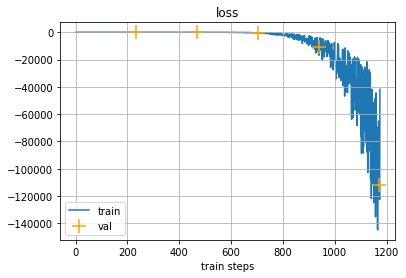

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=1e-5)
train(model, opt, 5)

Извлеките векторные описания тестовых изображений (a.k.a эмбеддинги). У вас должно получиться 10000 128-мерных векторов.

In [ ]:
testImages = test_dataset.test_data
embeddings = model(Variable(test_dataset.test_data.view(-1,1,28,28)).float())

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


Код ниже демонстрирует поисковую выдачу для трех изображений-запросов. Выдача формируется на основе близости эмбеддингов.

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


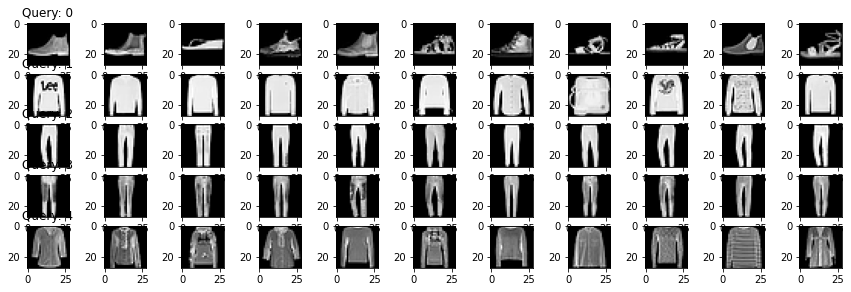

In [ ]:
queryCount = 5
queries = embeddings[:queryCount,:].data.numpy()
database = embeddings[queryCount:,:].data.numpy()
plt.figure(figsize=[15, 4.5])
for i in range(queryCount):
    results = np.argsort(np.sum((database-queries[i,:])**2, axis=1))[:10]
    plt.subplot(queryCount, 11, i * 11 + 1)
    plt.title("Query: %i" % i)
    plt.imshow(test_dataset.test_data[i].numpy().reshape([28, 28]), cmap='gray')
    for k in range(10):
        plt.subplot(queryCount, 11, i * 11 + k + 2)
        plt.imshow(test_dataset.test_data[results[k]+queryCount].numpy().reshape([28, 28]), cmap='gray')